In [3]:
# Using Sarima to do forecast for BTC price based on historical data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime

warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [4]:
# download the file
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
print(df.head())

    Timestamp  Open  High   Low  Close  Volume_(BTC)  Volume_(Currency)  \
0  1325317920  4.39  4.39  4.39   4.39      0.455581                2.0   
1  1325317980   NaN   NaN   NaN    NaN           NaN                NaN   
2  1325318040   NaN   NaN   NaN    NaN           NaN                NaN   
3  1325318100   NaN   NaN   NaN    NaN           NaN                NaN   
4  1325318160   NaN   NaN   NaN    NaN           NaN                NaN   

   Weighted_Price  
0            4.39  
1             NaN  
2             NaN  
3             NaN  
4             NaN  


In [5]:
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# Reorganize to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()

# Reorganize to monthly frequency
df_month = df.resample('M').mean()

# Reorganize to annual frequency
df_year = df.resample('A-DEC').mean()

# Reorganize to quarterly frequency
df_Q = df.resample('Q-DEC').mean()
print(df_month.tail())

                    Open          High           Low         Close  \
Timestamp                                                            
2020-11-30  16530.188884  16540.060546  16519.995766  16530.432867   
2020-12-31  21810.891586  21825.256165  21796.032856  21811.295270   
2021-01-31  34553.473084  34593.508742  34511.853676  34553.599446   
2021-02-28  46076.500756  46116.985465  46035.188338  46077.063198   
2021-03-31  54639.891296  54674.763269  54605.192891  54641.412965   

            Volume_(BTC)  Volume_(Currency)  Weighted_Price  
Timestamp                                                    
2020-11-30      6.684712      110828.794944    16530.401656  
2020-12-31      5.740538      129193.865128    21810.922846  
2021-01-31     10.249651      352391.120149    34551.684656  
2021-02-28      5.964004      274306.654409    46074.940877  
2021-03-31      3.527373      192206.908427    54638.339142  


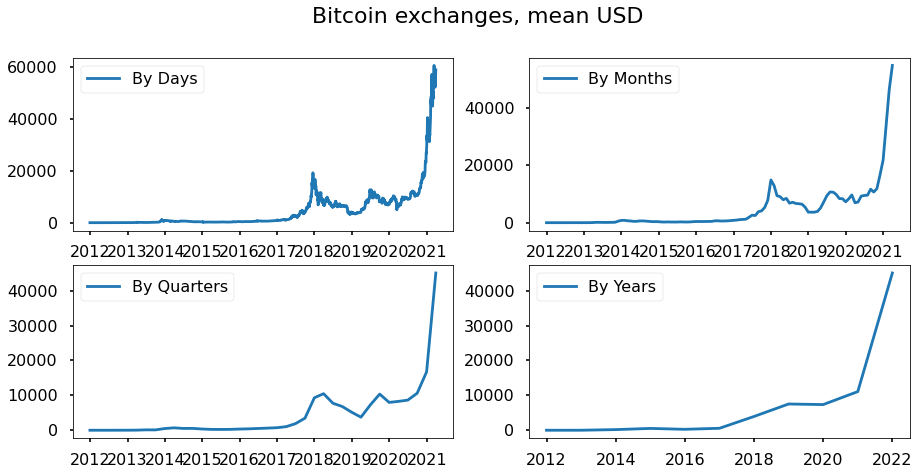

In [6]:
# show pic
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

plt.show()

Dickey–Fuller test: p=0.998863


<Figure size 1080x504 with 0 Axes>

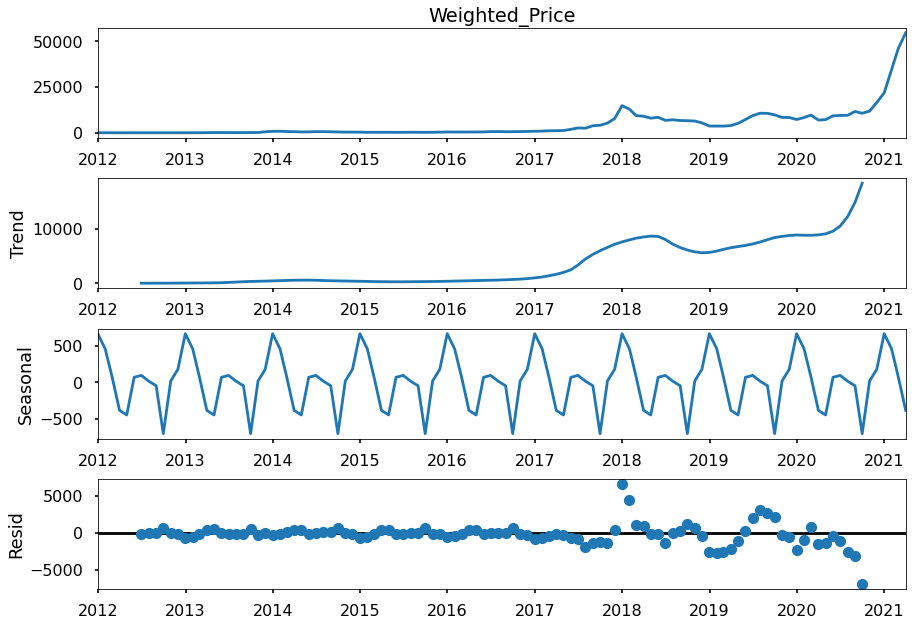

In [7]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("DF test res: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

In [8]:
# Box Cox transform
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

Dickey–Fuller test: p=0.998863


In [9]:
# Check Seasonal differentiation
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.444282


Dickey–Fuller test: p=0.000024


<Figure size 1080x504 with 0 Axes>

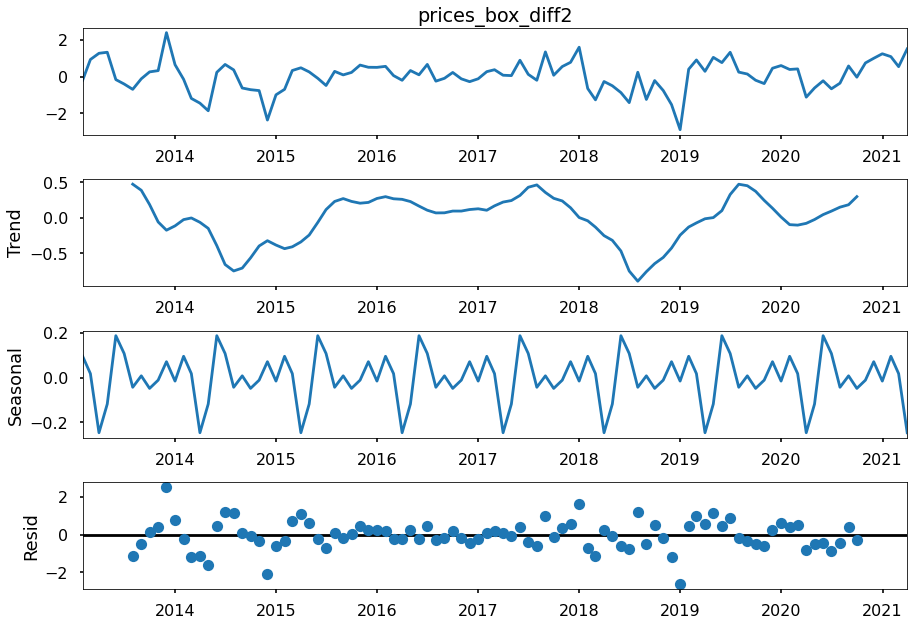

In [10]:
# Check Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# Run STL decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

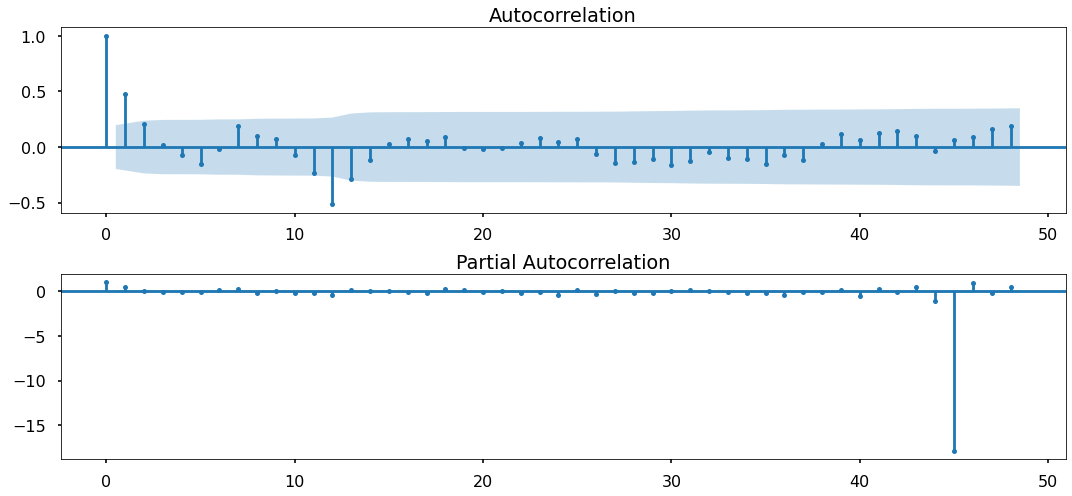

In [11]:
# Set up params using auto-corelation and partial plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [12]:
# Init params for model
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# run model
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [13]:
# Choose a best model
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  173.616562
21  (1, 0, 1, 1)  174.766384
25  (1, 1, 0, 1)  175.546984
37  (2, 0, 0, 1)  175.554499
7   (0, 1, 0, 1)  175.588562
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                  112
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -83.808
Date:                              Sun, 20 Jun 2021   AIC                            173.617
Time:                                      20:09:52   BIC                            181.402
Sample:                                  12-31-2011   HQIC                           176.767
                                       - 03-31-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

DF test:: p=0.000000


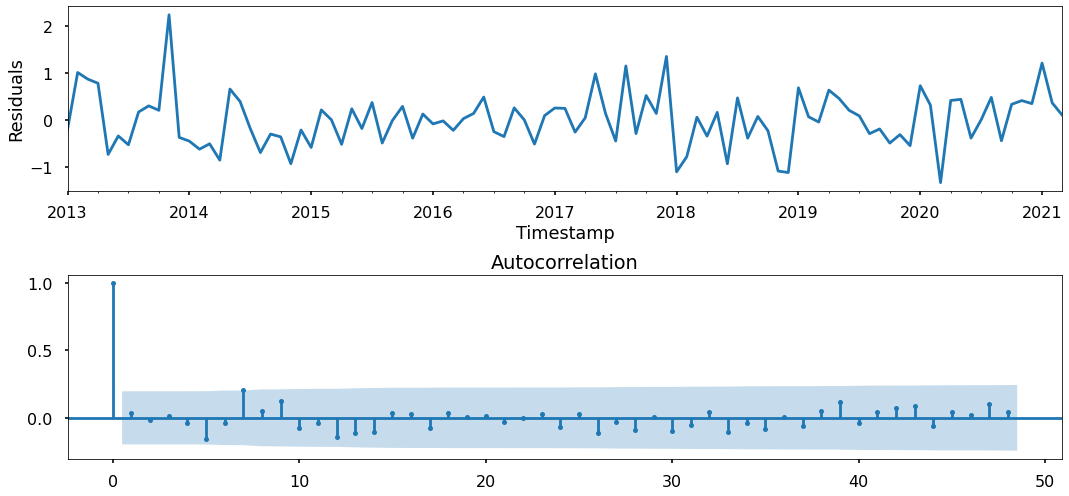

In [29]:
# STL decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("DF test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [27]:
# Inverse Box Cox transform
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

            Weighted_Price Open High  Low Close Volume_(BTC)  \
2011-12-31        4.471603  NaN  NaN  NaN   NaN          NaN   
2012-01-31        6.208550  NaN  NaN  NaN   NaN          NaN   
2012-02-29        5.252527  NaN  NaN  NaN   NaN          NaN   
2012-03-31        4.962021  NaN  NaN  NaN   NaN          NaN   
2012-04-30        4.976547  NaN  NaN  NaN   NaN          NaN   
...                    ...  ...  ...  ...   ...          ...   
2020-11-30             NaN  NaN  NaN  NaN   NaN          NaN   
2020-12-31             NaN  NaN  NaN  NaN   NaN          NaN   
2021-01-31             NaN  NaN  NaN  NaN   NaN          NaN   
2021-02-28             NaN  NaN  NaN  NaN   NaN          NaN   
2021-03-31             NaN  NaN  NaN  NaN   NaN          NaN   

           Volume_(Currency) Weighted_Price_box prices_box_diff  \
2011-12-31               NaN                NaN             NaN   
2012-01-31               NaN                NaN             NaN   
2012-02-29               NaN  

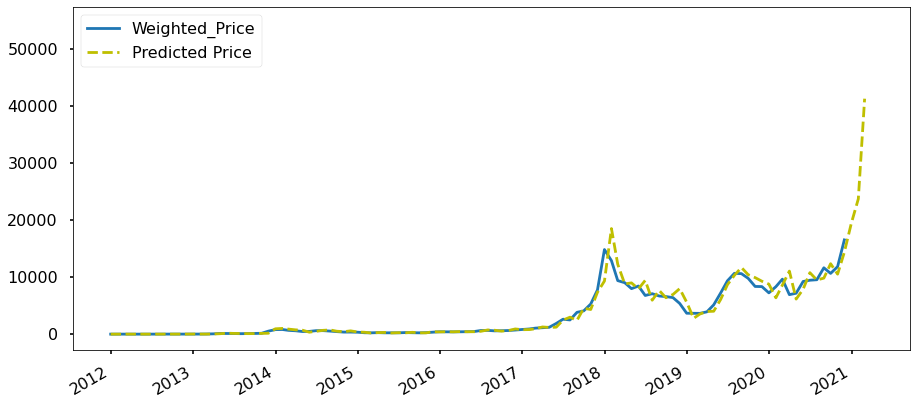

In [34]:
# Prediction
df_month2 = df_month[['Weighted_Price']]
# date_list = [datetime(2017, 6, 30), datetime(2017, 7, 31), datetime(2017, 8, 31), datetime(2017, 9, 30), 
#              datetime(2017, 10, 31), datetime(2017, 11, 30), datetime(2017, 12, 31), datetime(2018, 1, 31),
#              datetime(2018, 2, 28), datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), 
#              datetime(2018, 6, 30), datetime(2018, 7, 31), datetime(2018, 8, 31), datetime(2018, 9, 30),
#              datetime(2018, 10, 31), datetime(2018, 11, 30), datetime(2018, 12, 31), datetime(2019, 1, 31),
#              datetime(2019, 2, 28), datetime(2019, 3, 31), datetime(2019, 4, 30), datetime(2019, 5, 31), 
#              datetime(2019, 6, 30), datetime(2019, 7, 31), datetime(2019, 8, 31), datetime(2019, 9, 30),
#              datetime(2019, 10, 31), datetime(2019, 11, 30), datetime(2019, 12, 31), datetime(2020, 1, 31),
#              datetime(2020, 2, 29), datetime(2020, 3, 31), datetime(2020, 4, 30), datetime(2020, 5, 31),
#              datetime(2020, 6, 30), datetime(2020, 7, 31), datetime(2020, 8, 31), datetime(2020, 9, 30),
#              datetime(2020, 10, 31), datetime(2020, 11, 30), datetime(2020, 12, 31), datetime(2021, 1, 31),
#              datetime(2021, 2, 28), datetime(2021, 3, 31)]
date_list = [datetime(2020, 11, 30), datetime(2020, 12, 31), datetime(2021, 1, 31),datetime(2021, 2, 28), datetime(2021, 3, 31)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
print(df_month2)
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=110), lmbda)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='y', ls='--', label='Predicted Price')
plt.legend()
# plt.title('Bitcoin exchanges, by months')
# plt.ylabel('mean USD')
plt.show()